# Cytotoxic ODEs Analytical Solution

$ \frac{d\Omega_{t}}{dt} = - \tilde{\rho}  \Omega_{t} $

$ \frac{d\chi_{t}}{dt} = \Delta  \Omega_{t} - \phi \chi_{t} $

$ \frac{\tilde{\rho} - \rho_{min}}{\rho_{max} - \rho_{min}} = \lambda\Rightarrow \tilde{\rho} = \rho_{min} + \lambda \cdot (\rho_{max} + \rho_{min})$


---
- Variables: $\Omega$ & $\chi$
- Parameters: $\lambda$, $\phi$, $\rho_{min}$, $\rho_{max}$, $\Omega_{0}$, & $\chi_{0}$

ok. in the senario of $\Omega_{0} = 1$ and $\chi_{0} = 1$. Also $\lambda \in [0, 1]$

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import numpy as np

from typing import Tuple, Optional
from scipy.integrate import solve_ivp

plt.rcParams.update({
    "mathtext.fontset": "stix",
    "font.family": "STIXGeneral",
    # "legend.fontsize": 14,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "axes.titlesize": 16,
    "axes.labelsize": 18,
})
mpl.rcParams['animation.embed_limit'] = 2000  

In [4]:
# def simulate_omega_chi(
#     delta: float,
#     phi: float,
#     rho_min: float,
#     rho_max: float,
#     t: np.ndarray,
#     omega0: float = 1.0,
#     chi0: float = 0.0,
#     equal_tol: float = 1e-12,
# ):
#     """
#     Analytic simulation of:
#         dΩ/dt = -ρ̃ Ω
#         dχ/dt = Δ Ω - φ χ
#     with Ω(0)=omega0, χ(0)=chi0, Δ∈[0,1], and ρ̃ = ρ_min + Δ(ρ_max - ρ_min).

#     Parameters
#     ----------
#     delta : float
#         Δ in [0, 1].
#     phi : float
#         φ > 0 (typically).
#     rho_min, rho_max : float
#         Bounds used to form ρ̃.
#     t : np.ndarray
#         1D array of time points.
#     omega0 : float, default=1.0
#         Initial Ω(0).
#     chi0 : float, default=0.0
#         Initial χ(0).
#     equal_tol : float
#         Tolerance to treat φ and ρ̃ as equal to avoid division by zero.

#     Returns
#     -------
#     Omega_t : np.ndarray
#     Chi_t : np.ndarray
#     rho_tilde : float
#     """
#     rho_tilde = rho_min + delta * (rho_max - rho_min)

#     t = np.asarray(t, dtype=float)
#     exp_rho = np.exp(-rho_tilde * t)
#     exp_phi = np.exp(-phi * t)

#     Omega_t = omega0 * exp_rho

#     if abs(phi - rho_tilde) > equal_tol:
#         Chi_t = chi0 * exp_phi + (delta * omega0) * (exp_rho - exp_phi) / (phi - rho_tilde)
#     else:
#         # limit as φ -> ρ̃
#         Chi_t = (chi0 + (delta * omega0) * t) * exp_phi

#     return Omega_t, Chi_t, rho_tilde

# # Example usage:
# # t = np.linspace(0, 10, 501)
# # Ω, χ, ρ̃ = simulate_omega_chi(delta=0.3, phi=0.8, rho_min=0.2, rho_max=1.4, t=t)

In [5]:
def simulate_ode(
    delta: float,
    phi: float,
    rho_min: float,
    rho_max: float,
    t: np.ndarray,
    omega0: float = 1.0,
    chi0: float = 0.0,
    rtol: float = 1e-8,
    atol: float = 1e-10,
    method: str = "DOP853", # "DOP853" or "RK45" 
) -> Tuple[np.ndarray, np.ndarray, float, Optional[float], Optional[float]]:
    """
    Numerical integration of:
        dΩ/dt = -ρ̃ Ω
        dχ/dt = Δ Ω - φ χ
    with Ω(0)=omega0, χ(0)=chi0, Δ∈[0,1], and ρ̃ = ρ_min + Δ(ρ_max - ρ_min).

    Parameters
    ----------
    delta : float
        Coupling coefficient Δ ∈ [0,1].
    phi : float
        Decay rate φ of χ (typically > 0).
    rho_min, rho_max : float
        Bounds for ρ̃. Effective decay is ρ̃ = ρ_min + Δ(ρ_max - ρ_min).
    t : np.ndarray
        1D array of time points at which the solution is returned.
    omega0 : float, default=1.0
        Initial value Ω(0).
    chi0 : float, default=0.0
        Initial value χ(0).
    rtol : float, default=1e-8
        Relative tolerance for the solver.
    atol : float, default=1e-10
        Absolute tolerance for the solver.
    method : str, default="RK45"
        Integration method passed to solve_ivp (e.g. 'RK45', 'RK23', 'Radau').

    Returns
    -------
    Omega_t : np.ndarray
        Values of Ω(t) at the times in `t`.
    Chi_t : np.ndarray
        Values of χ(t) at the times in `t`.
    rho_tilde : float
        Effective decay parameter ρ̃.
    t_peak : float or None
        Time at which χ(t) reaches its maximum (None if no peak detected).
    chi_peak : float or None
        Maximum value χ(t_peak) (None if no peak detected).
    """
    t = np.asarray(t, dtype=float)
    rho_tilde = rho_min + delta * (rho_max - rho_min)

    def rhs(_t, y):
        Omega, Chi = y
        dOmega = -rho_tilde * Omega
        dChi = delta * Omega - phi * Chi
        return [dOmega, dChi]

    # Event: dχ/dt = 0 (peak condition)
    def dchi_dt_event(_t, y):
        Omega, Chi = y
        return delta * Omega - phi * Chi
    dchi_dt_event.terminal = False   # don't stop integration
    dchi_dt_event.direction = -1     # only detect when slope changes from + to - (maxima)

    sol = solve_ivp(
        rhs,
        t_span=(t[0], t[-1]),
        y0=[omega0, chi0],
        t_eval=t,
        method=method,
        rtol=rtol,
        atol=atol,
        events=dchi_dt_event,
        dense_output=True,  
    )

    if not sol.success:
        raise RuntimeError(f"ODE solver failed: {sol.message}")

    Omega_t, Chi_t = sol.y

    # Peak detection
    if sol.t_events[0].size > 0:
        t_peak = sol.t_events[0][0]
        # interpolate chi at t_peak
        Omega_peak, Chi_peak = sol.sol(t_peak)
        chi_peak = Chi_peak
    else:
        t_peak, chi_peak = None, None

    return Omega_t, Chi_t, rho_tilde, t_peak, chi_peak

# # Example usage:
# if __name__ == "__main__":
#     import matplotlib.pyplot as plt

#     t = np.linspace(0, 10, 500)
#     Ω, χ, ρ̃, t_peak, χ_peak = simulate_omega_chi_ode(
#         delta=0.5, phi=0.8, rho_min=0, rho_max=1, t=t
#     )

#     plt.plot(t, χ, label="χ(t)")
#     if t_peak is not None:
#         plt.plot(t_peak, χ_peak, "ro", label="peak")
#     plt.legend()
#     plt.show()

### i. without recovery | without exhaustion
$\phi = 0$ & $\tilde{\rho} = 0$

---
$\Omega_{t} = \Omega_{0}$

$\chi_{t} = \Delta \Omega_{0} t + \chi_{0}$

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


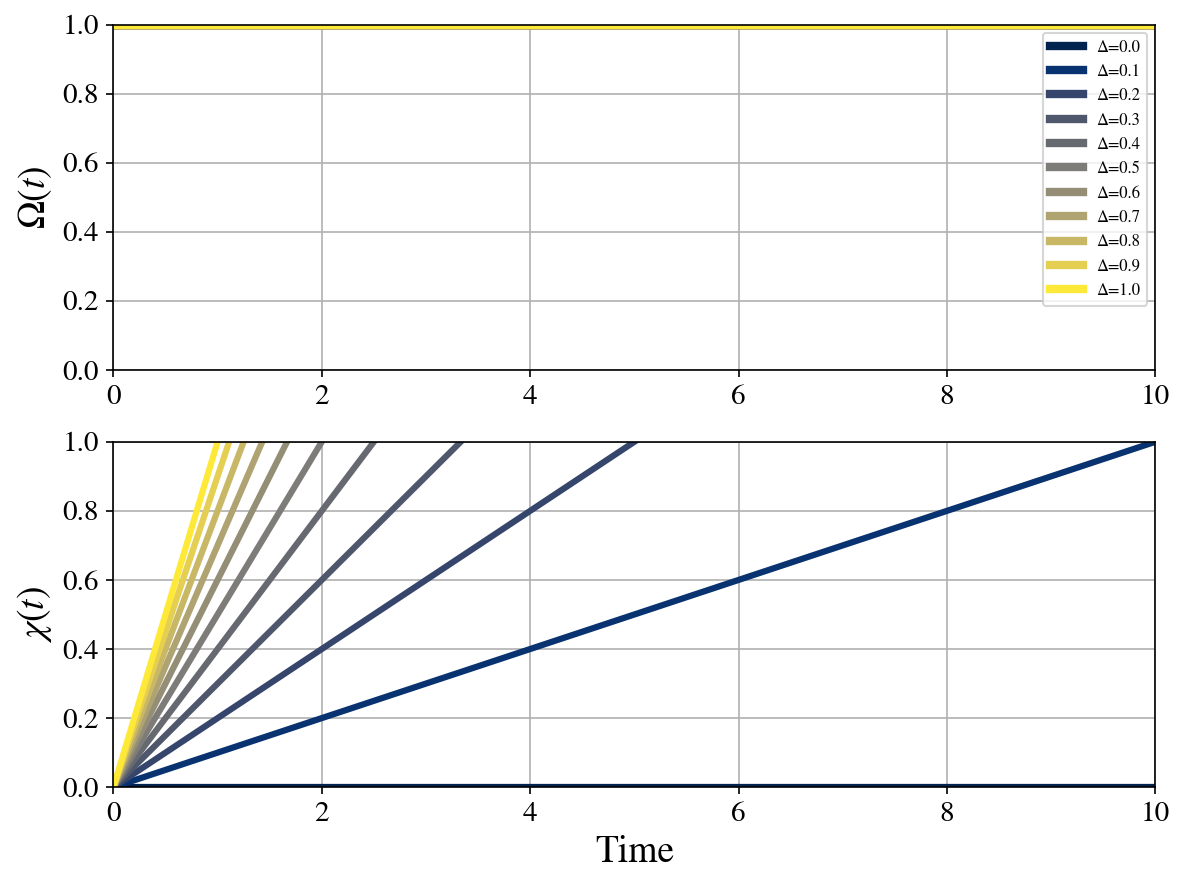

In [6]:
# Time vector
t_total = 10
t = np.linspace(0, t_total, 500)

# Parameters
phi = 0
rho_min = 0
rho_max = 0
deltas = np.round(np.arange(0, 1.1, 0.1), 1)
print(deltas)

plt.figure(figsize=(8, 6), dpi=150)
colors = cm.cividis(np.linspace(0, 1, len(deltas)))


# --- Ω(t) subplot ---
plt.subplot(2, 1, 1)
for delta, color in zip(deltas, colors):
    Ω, χ, _, _, _ = simulate_ode(delta, phi, rho_min, rho_max, t)
    plt.plot(t, Ω, label=f"Δ={delta}", color=color, linewidth=4)
plt.ylabel(r"$\Omega(t)$")
# plt.title("Dynamics of Ω and χ for different Δ")
plt.legend(loc="upper right", fontsize=8)
plt.grid(True)
plt.xlim(0, t_total)
plt.ylim(0, 1)

# --- χ(t) subplot ---
plt.subplot(2, 1, 2)
for delta, color in zip(deltas, colors):
    Ω, χ, _, _, _ = simulate_ode(delta, phi, rho_min, rho_max, t)
    plt.plot(t, χ, label=f"Δ={delta}", color=color, linewidth=3)
plt.xlabel("Time")
plt.ylabel(r"$\chi(t)$")
plt.grid(True)
plt.xlim(0, t_total)
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

### ii. without recovery | with exhaustion
$\phi = 0$ & $\tilde{\rho} > 0$

---
$\Omega_{t} = \Omega_{0}e^{-\tilde{\rho}t}$

$\chi_{t} = \chi_{0}+\frac{\Delta \Omega_{0}}{\tilde{\rho}}(1-e^{-\tilde{\rho}t})$

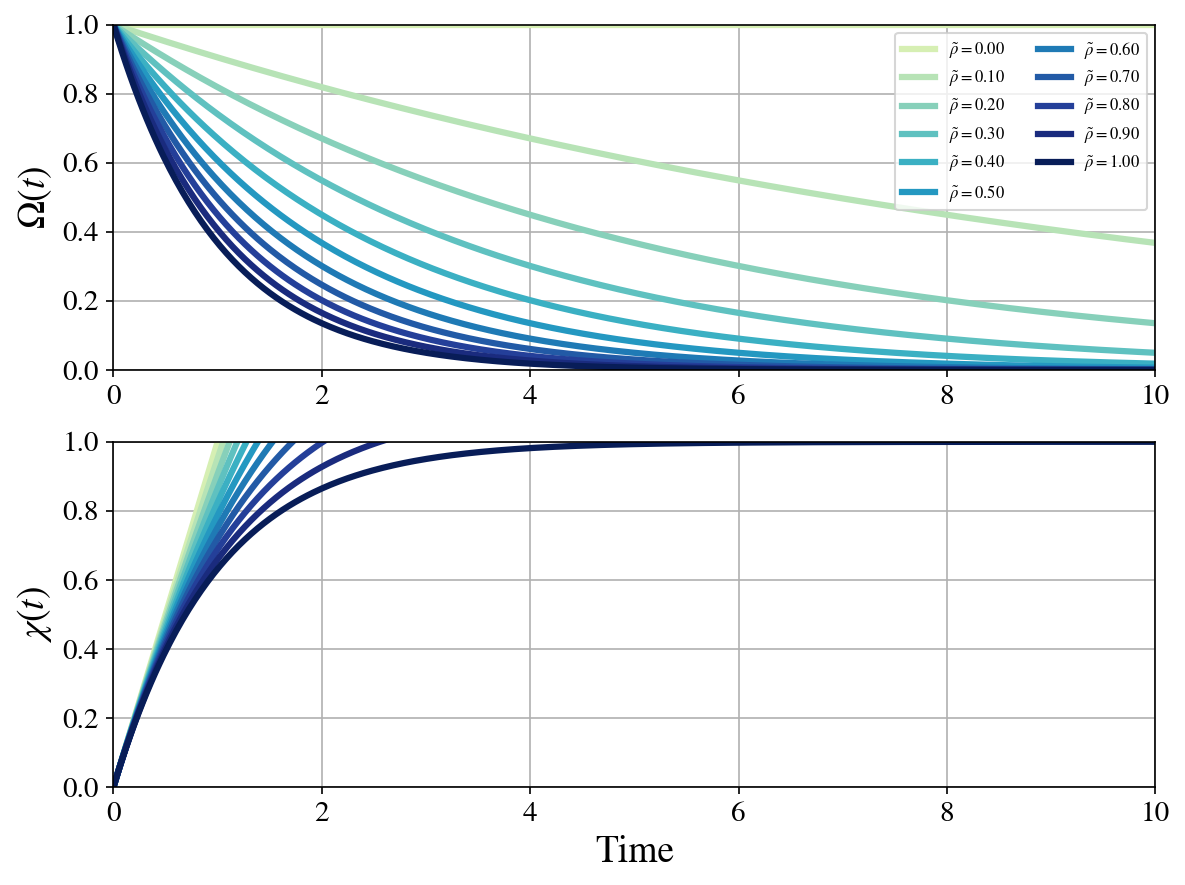

In [7]:
# --- Time vector
t_total = 10
t = np.linspace(0, t_total, 500)

# --- Parameters
phi = 0.0
rho_min = 0.0
delta_fixed = 1.0              # choose the Δ you want for this scan
rho_max_values = np.round(np.arange(0.0, 1.1, 0.1), 1)  # 0.0, 0.1, ..., 1.0

# colours mapped to rho_max
colors = cm.YlGnBu(np.linspace(0.2, 1, len(rho_max_values)))

plt.figure(figsize=(8, 6), dpi=150)

# --- Ω(t) subplot ---
plt.subplot(2, 1, 1)
for rmax, color in zip(rho_max_values, colors):
    Ω, χ, ρ̃, _, _ = simulate_ode(delta_fixed, phi, rho_min, float(rmax), t)
    plt.plot(t, Ω, label=fr"$\tilde{{\rho}}={ρ̃:.2f}$", color=color, linewidth=3)
plt.ylabel(r"$\Omega(t)$")
plt.legend(loc="upper right", fontsize=8, ncols=2)
plt.grid(True)
plt.xlim(0, t_total)
plt.ylim(0, 1.0)

# --- χ(t) subplot ---
plt.subplot(2, 1, 2)
for rmax, color in zip(rho_max_values, colors):
    Ω, χ, ρ̃, _, _ = simulate_ode(delta_fixed, phi, rho_min, float(rmax), t)
    plt.plot(t, χ, label=fr"$\tilde{{\rho}}={ρ̃:.2f}$", color=color, linewidth=3)
plt.xlabel("Time")
plt.ylabel(r"$\chi(t)$")
# plt.legend(loc="upper right", fontsize=8, ncols=2)
plt.grid(True)
plt.xlim(0, t_total)
plt.ylim(0, 1.0)

plt.tight_layout()
plt.show()

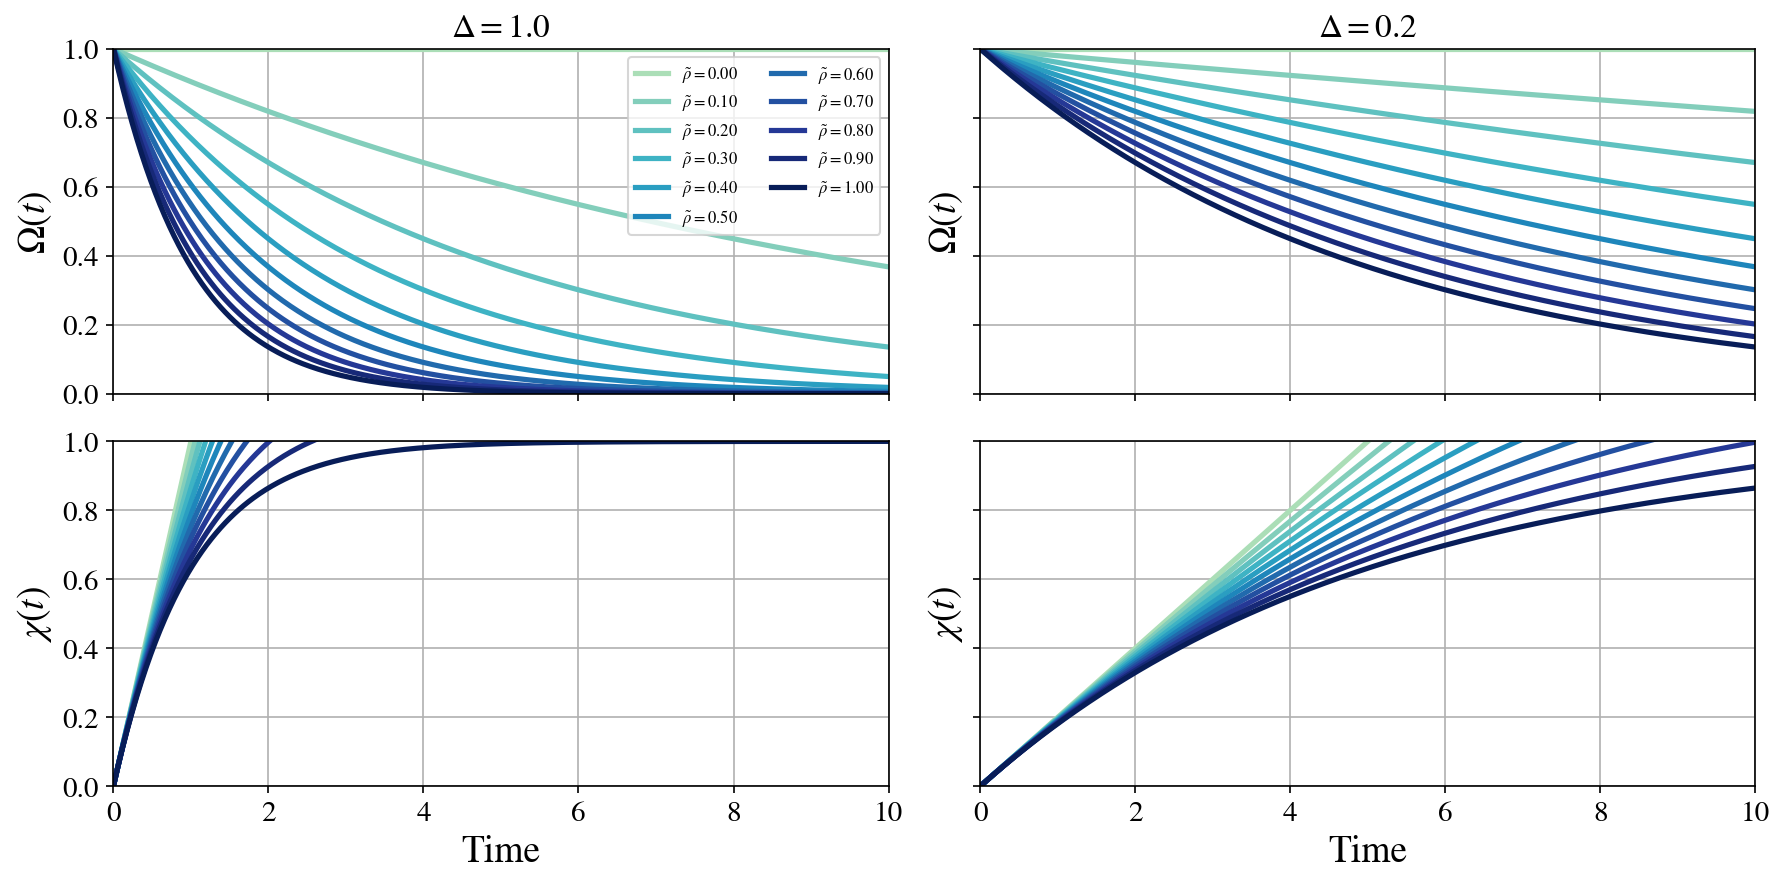

In [8]:
# --- Time vector
t_total = 10
t = np.linspace(0, t_total, 500)

# --- Parameters
phi = 0.0
rho_min = 0.0
rho_max_values = np.round(np.arange(0.0, 1.1, 0.1), 1)  # 0.0, 0.1, ..., 1.0

# Colours mapped to rho_max
colors = cm.YlGnBu(np.linspace(0.3, 1, len(rho_max_values)))

# --- Two deltas to compare
deltas_to_compare = [1.0, 0.2]

fig, axes = plt.subplots(2, 2, figsize=(12, 6), dpi=150, sharex=True, sharey='row')

for col, delta_fixed in enumerate(deltas_to_compare):
    # --- Ω(t) subplot ---
    ax_omega = axes[0, col]
    for rmax, color in zip(rho_max_values, colors):
        Ω, χ, ρ̃, _, _ = simulate_ode(delta_fixed, phi, rho_min, float(rmax), t)
        ax_omega.plot(t, Ω, label=fr"$\tilde{{\rho}}={ρ̃:.2f}$", color=color, linewidth=2.5)
    ax_omega.set_ylabel(r"$\Omega(t)$")
    ax_omega.set_title(fr"$\Delta = {delta_fixed}$")
    ax_omega.grid(True)
    ax_omega.set_xlim(0, t_total)
    ax_omega.set_ylim(0, 1.0)
    if col == 0:
        ax_omega.legend(loc="upper right", fontsize=8, ncols=2)

    # --- χ(t) subplot ---
    ax_chi = axes[1, col]
    for rmax, color in zip(rho_max_values, colors):
        Ω, χ, ρ̃, _, _ = simulate_ode(delta_fixed, phi, rho_min, float(rmax), t)
        ax_chi.plot(t, χ, label=fr"$\tilde{{\rho}}={ρ̃:.2f}$", color=color, linewidth=2.5)
    ax_chi.set_xlabel("Time")
    ax_chi.set_ylabel(r"$\chi(t)$")
    ax_chi.grid(True)
    ax_chi.set_xlim(0, t_total)
    ax_chi.set_ylim(0, 1.0)

plt.tight_layout()
plt.show()

### iii. with recovery | without exhaustion
$\phi > 0$ & $\tilde{\rho} = 0$

---
$\Omega_{t} = \Omega_{0}$

$\chi_{t} = \frac{\Omega_{0}}{\phi} + (\chi_{0} - \frac{\Omega_{0}}{\phi})e^{-\phi t}$

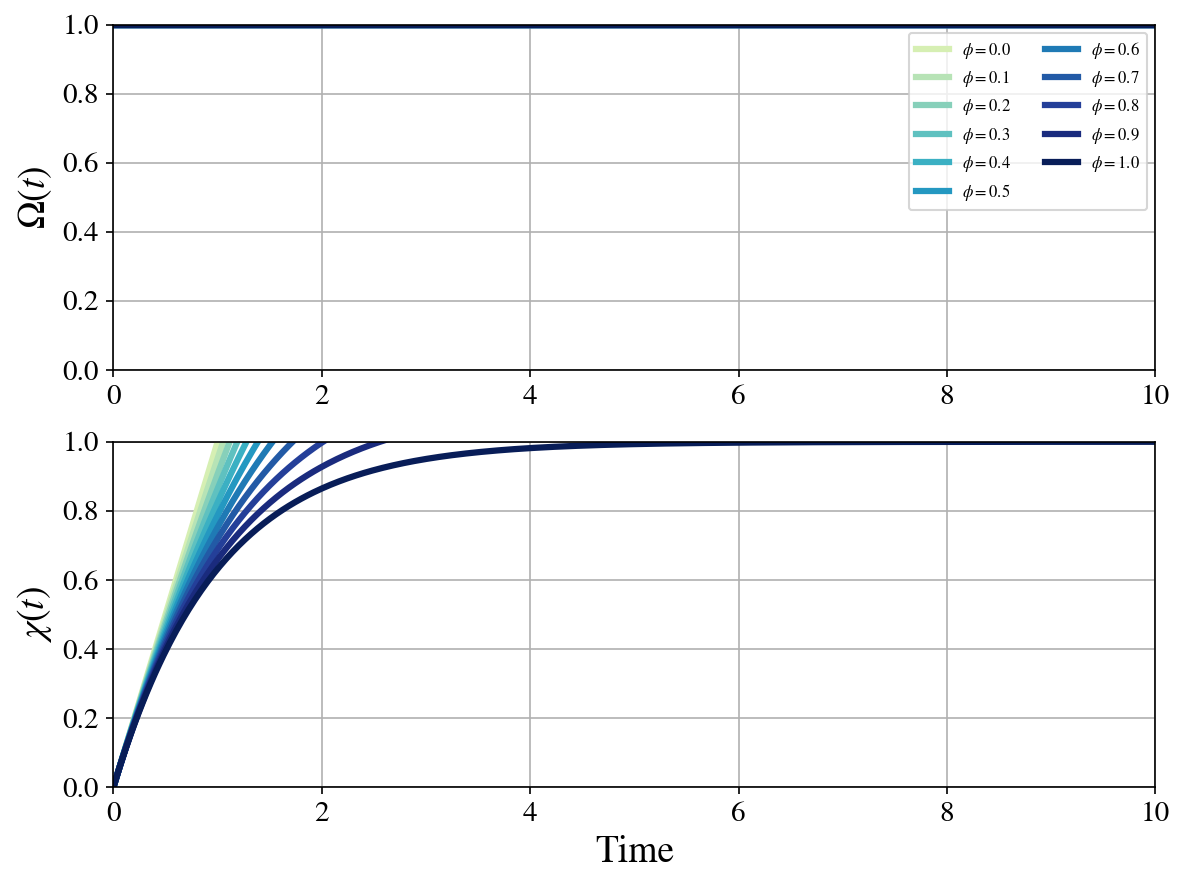

In [9]:
# --- Time vector
t_total = 10
t = np.linspace(0, t_total, 500)

# --- Parameters
phi_values = np.round(np.arange(0.0, 1.1, 0.1), 1)   # φ = 0.0, 0.1, ..., 1.0
rho_min = 0.0
rho_max = 0          # keep rho_max fixed
delta_fixed = 1.0       # fixed Δ

# --- Colours mapped to φ
colors = cm.YlGnBu(np.linspace(0.2, 1, len(phi_values)))

plt.figure(figsize=(8, 6), dpi=150)

# --- Ω(t) subplot ---
plt.subplot(2, 1, 1)
for phi, color in zip(phi_values, colors):
    Ω, χ, ρ̃, _, _ = simulate_ode(delta_fixed, float(phi), rho_min, rho_max, t)
    plt.plot(t, Ω, label=fr"$\phi={phi:.1f}$", color=color, linewidth=3)
plt.ylabel(r"$\Omega(t)$")
plt.legend(loc="upper right", fontsize=8, ncols=2)
plt.grid(True)
plt.xlim(0, t_total)
plt.ylim(0, 1.0)

# --- χ(t) subplot ---
plt.subplot(2, 1, 2)
for phi, color in zip(phi_values, colors):
    Ω, χ, ρ̃, _, _ = simulate_ode(delta_fixed, float(phi), rho_min, rho_max, t)
    plt.plot(t, χ, label=fr"$\phi={phi:.1f}$", color=color, linewidth=3)
plt.xlabel("Time")
plt.ylabel(r"$\chi(t)$")
# plt.legend(loc="upper right", fontsize=8, ncols=2)  # optional
plt.grid(True)
plt.xlim(0, t_total)
plt.ylim(0, 1.0)

plt.tight_layout()
plt.show()

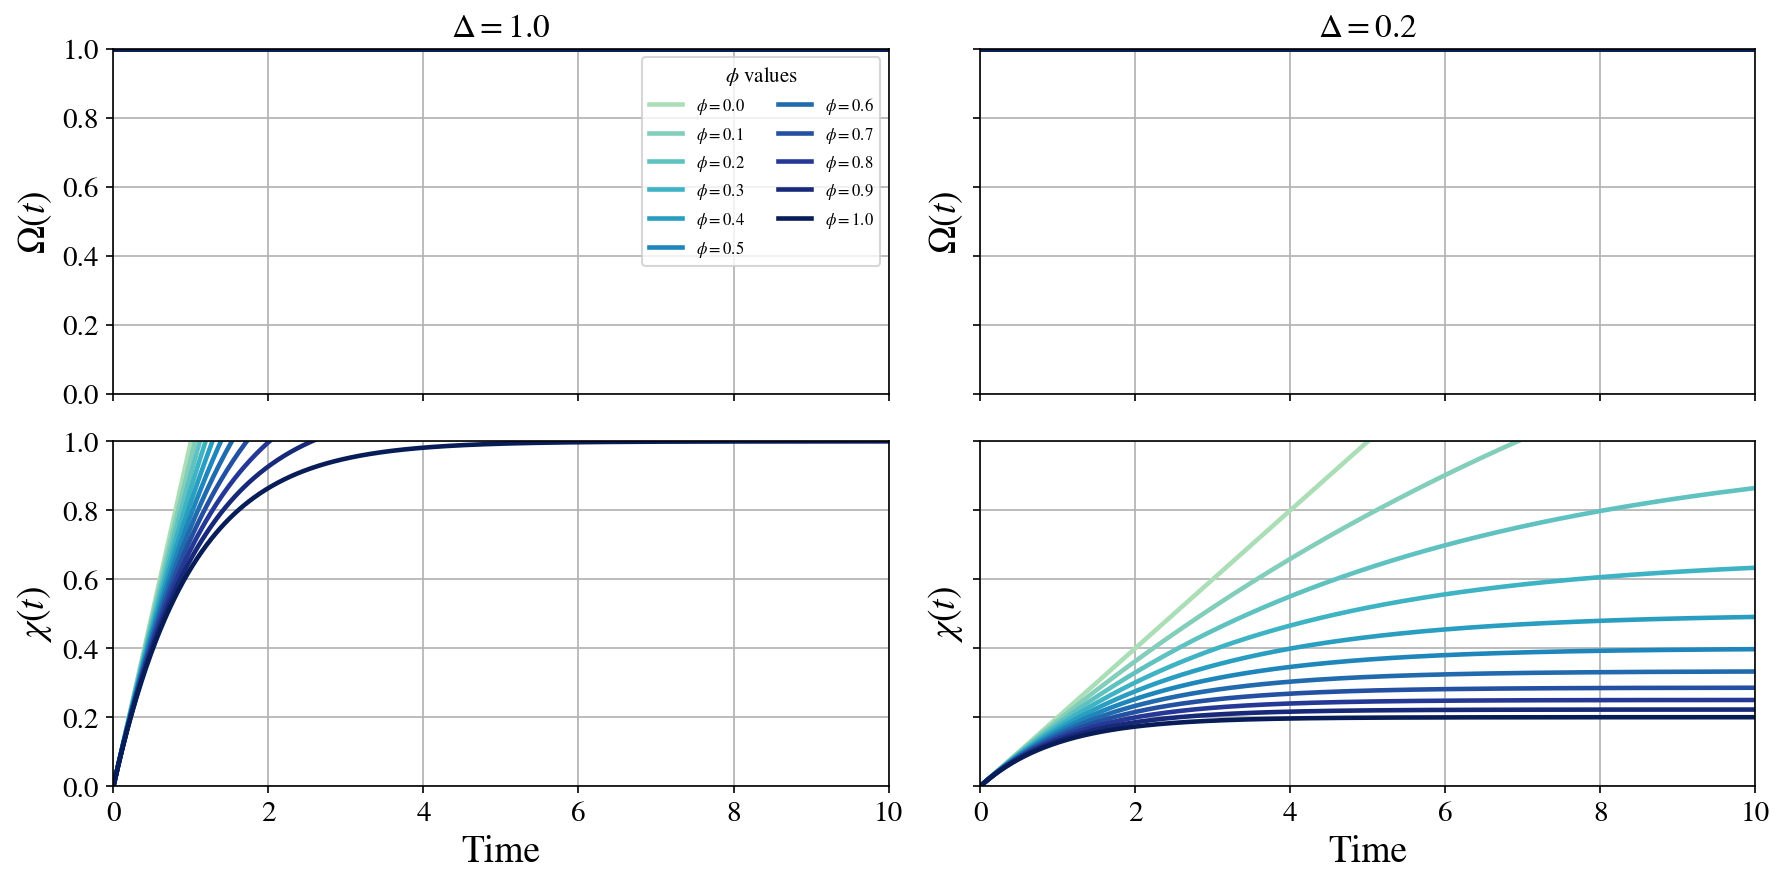

In [10]:
# --- Time vector
t_total = 10
t = np.linspace(0, t_total, 500)

# --- Parameters
rho_min = 0.0
rho_max = 0.0         # fixed at zero
phi_values = np.round(np.arange(0.0, 1.1, 0.1), 1)  # φ = 0.0 ... 1.0

# --- Two Δ to compare
deltas_to_compare = [1.0, 0.2]

# --- Colour map for φ
colors = cm.YlGnBu(np.linspace(0.3, 1, len(phi_values)))

fig, axes = plt.subplots(2, 2, figsize=(12, 6), dpi=150, sharex=True, sharey='row')

for col, delta_fixed in enumerate(deltas_to_compare):
    # --- Ω(t) subplot (top row)
    ax_omega = axes[0, col]
    for phi, color in zip(phi_values, colors):
        Ω, χ, ρ̃, _, _ = simulate_ode(delta_fixed, float(phi), rho_min, rho_max, t)
        ax_omega.plot(t, Ω, color=color, linewidth=2.2, label=fr"$\phi={phi:.1f}$")
    ax_omega.set_title(fr"$\Delta = {delta_fixed}$")
    ax_omega.set_ylabel(r"$\Omega(t)$")
    ax_omega.grid(True)
    ax_omega.set_xlim(0, t_total)
    ax_omega.set_ylim(0, 1.0)

    # --- χ(t) subplot (bottom row)
    ax_chi = axes[1, col]
    for phi, color in zip(phi_values, colors):
        Ω, χ, ρ̃, _, _ = simulate_ode(delta_fixed, float(phi), rho_min, rho_max, t)
        ax_chi.plot(t, χ, color=color, linewidth=2.2, label=fr"$\phi={phi:.1f}$")
    ax_chi.set_xlabel("Time")
    ax_chi.set_ylabel(r"$\chi(t)$")
    ax_chi.grid(True)
    ax_chi.set_xlim(0, t_total)
    ax_chi.set_ylim(0, 1.0)

# --- Only one legend (top-left) to avoid clutter
axes[0, 0].legend(loc="upper right", fontsize=8, ncols=2, title=r"$\phi$ values")

plt.tight_layout()
plt.show()

### iv. with recovery | with exhaustion
$\phi > 0$ & $\tilde{\rho} > 0$

---
$\Omega_{t} = \Omega_{0}e^{-\tilde{\rho}t}$

$\chi_t = \left( \Delta \Omega_0 t + \chi_0 \right) e^{-\phi t}
\quad \text{if } \phi = \tilde{\rho}$

$\chi_t = \frac{\Delta \Omega_0}{\phi - \tilde{\rho}}
\left( e^{-\tilde{\rho} t} - e^{-\phi t} \right) + \chi_0 e^{-\phi t}
\quad \text{if } \phi \neq \tilde{\rho}$

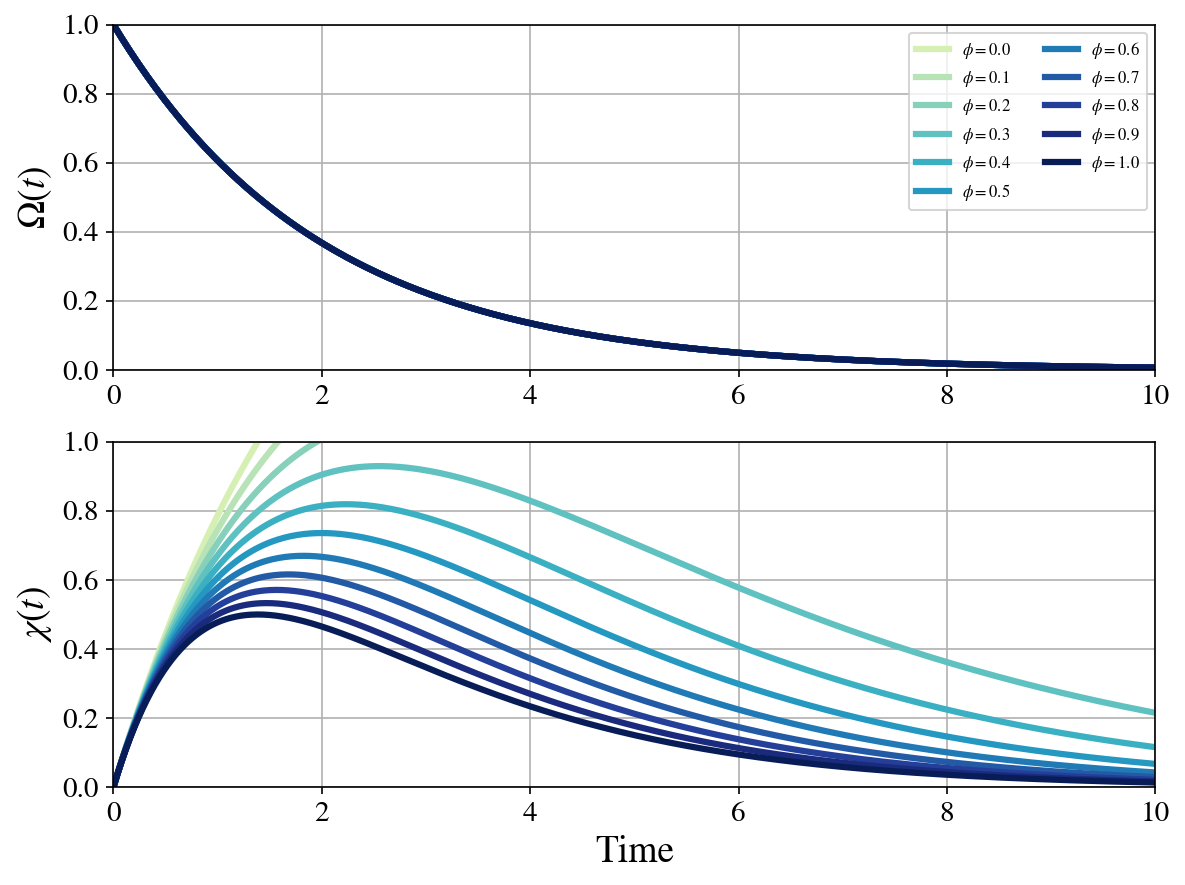

In [11]:
def _truncate_at_level(t, y, level=1.0):
    """Return t_trim, y_trim cut at the first time y crosses 'level' from below.
    Includes an interpolated endpoint exactly at the crossing."""
    y = np.asarray(y)
    t = np.asarray(t)
    # indices where y goes from < level to >= level
    cross_idx = np.where((y[:-1] < level) & (y[1:] >= level))[0]
    if cross_idx.size == 0:
        return t, y, None, None  # no crossing
    k = cross_idx[0]
    # linear interpolation fraction between k and k+1
    dy = y[k+1] - y[k]
    if dy == 0:
        alpha = 0.0
    else:
        alpha = (level - y[k]) / dy
    t_cross = t[k] + alpha * (t[k+1] - t[k])
    # build trimmed arrays (include exact crossing point)
    t_trim = np.concatenate([t[:k+1], [t_cross]])
    y_trim = np.concatenate([y[:k+1], [level]])
    return t_trim, y_trim, k, t_cross

# --- Time vector
t_total = 10
t = np.linspace(0, t_total, 500)

# --- Parameters
phi_values = np.round(np.arange(0.0, 1.1, 0.1), 1)
rho_min = 0.0
rho_max = 0.5
delta_fixed = 1.0

# --- Colours mapped to φ
colors = cm.YlGnBu(np.linspace(0.2, 1, len(phi_values)))

plt.figure(figsize=(8, 6), dpi=150)

# --- Ω(t) subplot ---
plt.subplot(2, 1, 1)
for phi, color in zip(phi_values, colors):
    Ω, χ, ρ̃, _, _ = simulate_ode(delta_fixed, float(phi), rho_min, rho_max, t)

    # trim χ at first time it reaches 1; apply same truncation to Ω
    t_chi, χ_trim, k, t_cross = _truncate_at_level(t, χ, level=1.0)
    if k is None:
        # never reaches 1 — plot full curve
        plt.plot(t, Ω, label=fr"$\phi={phi:.1f}$", color=color, linewidth=3)
    else:
        # interpolate Ω at the same crossing time for a neat endpoint
        Ω_cross = Ω[k] + (Ω[k+1] - Ω[k]) * (t_cross - t[k]) / (t[k+1] - t[k])
        Ω_trim = np.concatenate([Ω[:k+1], [Ω_cross]])
        plt.plot(t_chi, Ω_trim, label=fr"$\phi={phi:.1f}$", color=color, linewidth=3)

plt.ylabel(r"$\Omega(t)$")
plt.legend(loc="upper right", fontsize=8, ncols=2)
plt.grid(True)
plt.xlim(0, t_total)
plt.ylim(0, 1.0)

# --- χ(t) subplot ---
plt.subplot(2, 1, 2)
for phi, color in zip(phi_values, colors):
    Ω, χ, ρ̃, _, _ = simulate_ode(delta_fixed, float(phi), rho_min, rho_max, t)

    t_chi, χ_trim, k, _ = _truncate_at_level(t, χ, level=1.0)
    plt.plot(t_chi, χ_trim, label=fr"$\phi={phi:.1f}$", color=color, linewidth=3)

plt.xlabel("Time")
plt.ylabel(r"$\chi(t)$")
plt.grid(True)
plt.xlim(0, t_total)
plt.ylim(0, 1.0)

plt.tight_layout()
plt.show()

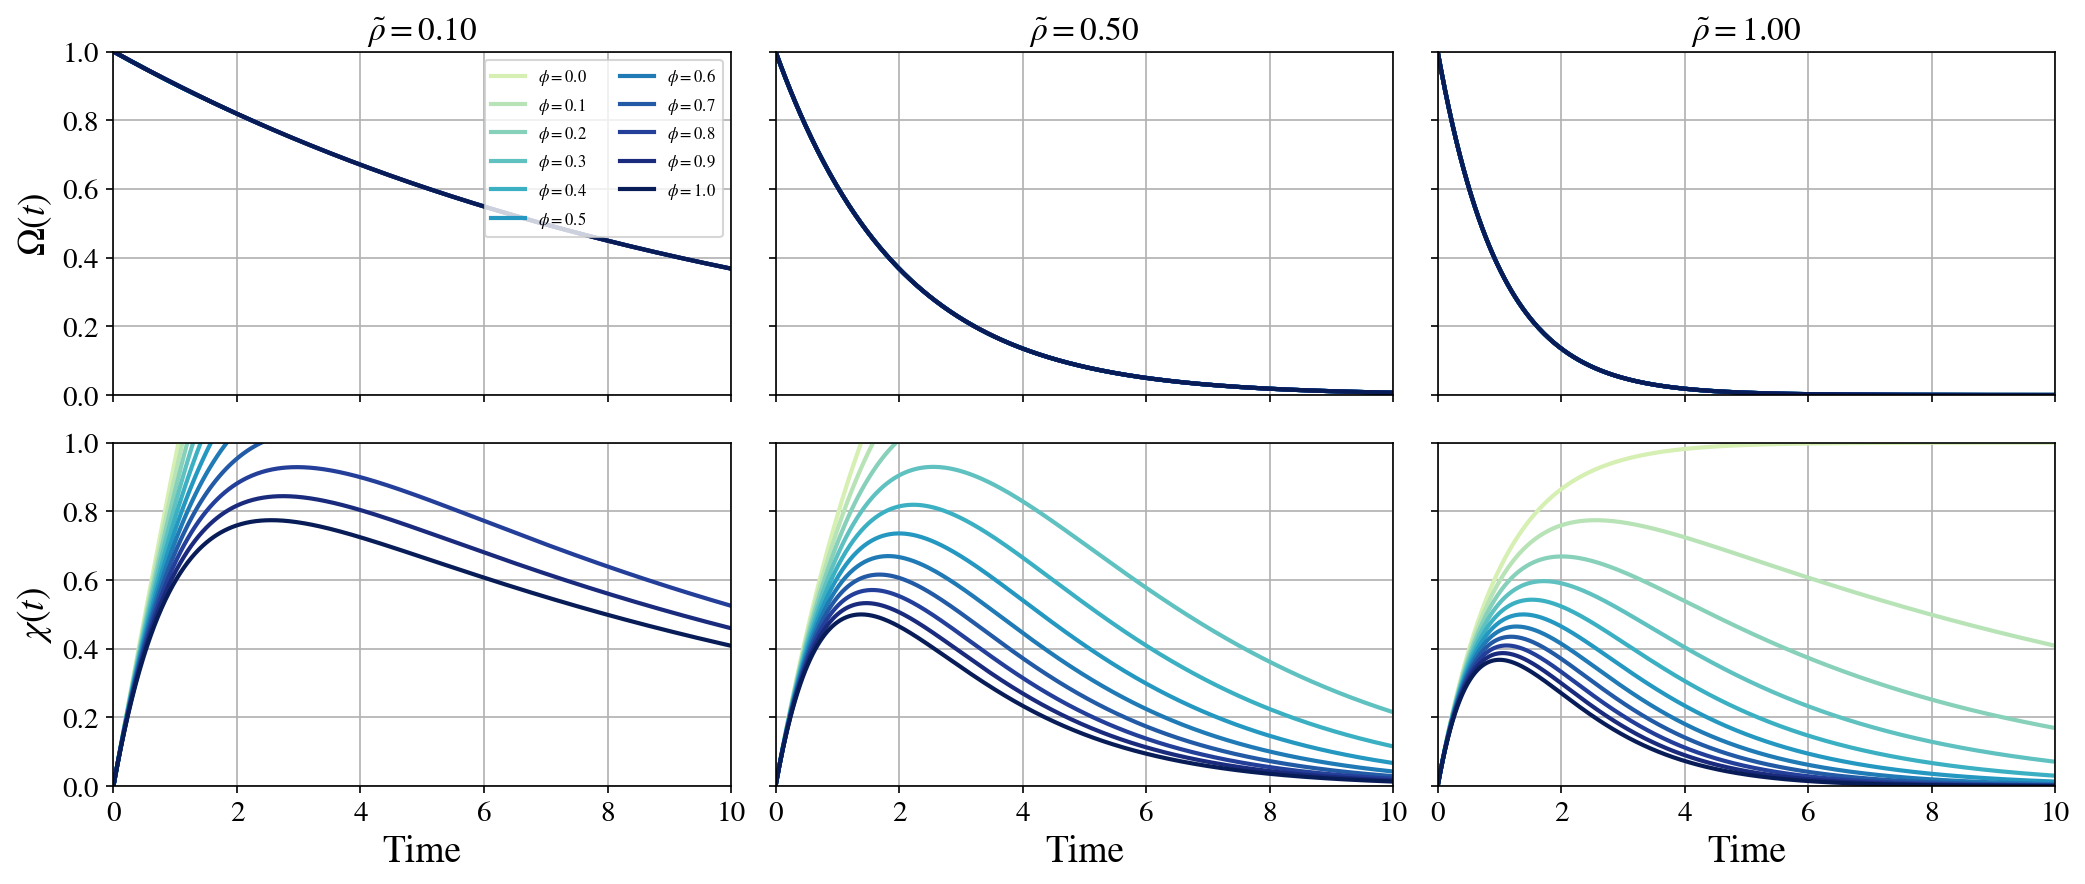

In [12]:
from matplotlib.lines import Line2D

# -------- Small multiples (2×3): columns = rho_max
fig, axes = plt.subplots(2, 3, figsize=(14, 6), dpi=150, sharex=True, sharey='row')
rho_max_list = [0.1, 0.5, 1.0] 
for col, rho_max in enumerate(rho_max_list):
    # Ω(t)
    ax_o = axes[0, col]
    for phi, color in zip(phi_values, colors):
        Ω, χ, ρ̃, _, _ = simulate_ode(delta_fixed, float(phi), rho_min, float(rho_max), t)
        t_chi, χ_trim, k, t_cross = _truncate_at_level(t, χ, level=1.0)
        if k is None:
            ax_o.plot(t, Ω, color=color, linewidth=2)
        else:
            Ω_cross = Ω[k] + (Ω[k+1]-Ω[k]) * (t_cross - t[k]) / (t[k+1] - t[k])
            Ω_trim = np.concatenate([Ω[:k+1], [Ω_cross]])
            ax_o.plot(t_chi, Ω_trim, color=color, linewidth=2)

    # show calculated \tilde{\rho} in title
    ax_o.set_title(rf"$\tilde{{\rho}}={ρ̃:.2f}$")

    ax_o.set_ylabel(r"$\Omega(t)$" if col==0 else "")
    ax_o.grid(True); ax_o.set_xlim(0, t_total); ax_o.set_ylim(0, 1.0)

    # χ(t)
    ax_c = axes[1, col]
    for phi, color in zip(phi_values, colors):
        Ω, χ, ρ̃, _, _ = simulate_ode(delta_fixed, float(phi), rho_min, float(rho_max), t)
        t_chi, χ_trim, _, _ = _truncate_at_level(t, χ, level=1.0)
        ax_c.plot(t_chi, χ_trim, color=color, linewidth=2)
    ax_c.set_xlabel("Time")
    ax_c.set_ylabel(r"$\chi(t)$" if col==0 else "")
    ax_c.grid(True); ax_c.set_xlim(0, t_total); ax_c.set_ylim(0, 1.0)
    
    

# --- Add legend only to the top-left subplot
legend_elements = [
    Line2D([0], [0], color=color, lw=2, label=fr"$\phi={phi:.1f}$")
    for phi, color in zip(phi_values, colors)
]
axes[0, 0].legend(handles=legend_elements, fontsize=8, ncol=2, loc="upper right")

plt.tight_layout()
plt.show()

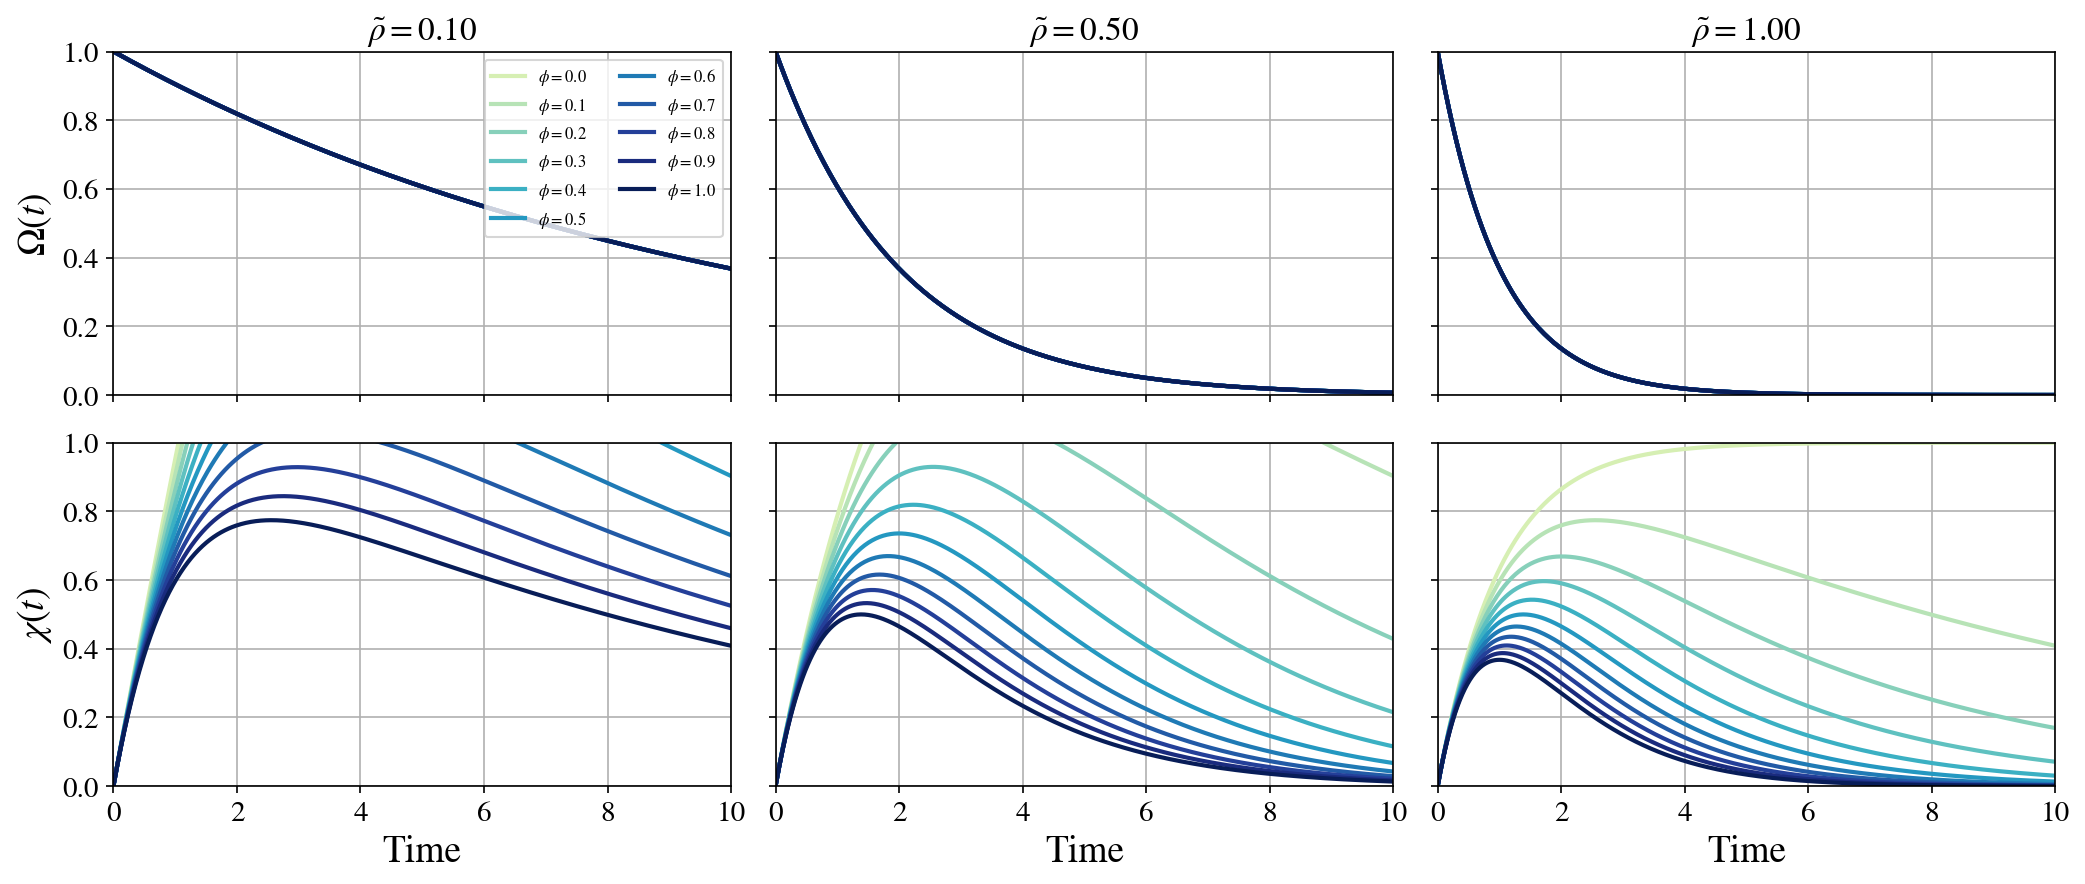

In [13]:
from matplotlib.lines import Line2D

# -------- Small multiples (2×3): columns = rho_max
fig, axes = plt.subplots(2, 3, figsize=(14, 6), dpi=150, sharex=True, sharey='row')
rho_max_list = [0.1, 0.5, 1.0] 

for col, rho_max in enumerate(rho_max_list):
    # Ω(t)
    ax_o = axes[0, col]
    for phi, color in zip(phi_values, colors):
        Ω, χ, ρ̃, _, _ = simulate_ode(delta_fixed, float(phi), rho_min, float(rho_max), t)
        ax_o.plot(t, Ω, color=color, linewidth=2)

    # show calculated \tilde{\rho} in title
    ax_o.set_title(rf"$\tilde{{\rho}}={ρ̃:.2f}$")

    ax_o.set_ylabel(r"$\Omega(t)$" if col == 0 else "")
    ax_o.grid(True)
    ax_o.set_xlim(0, t_total)
    ax_o.set_ylim(0, 1.0)

    # χ(t)
    ax_c = axes[1, col]
    for phi, color in zip(phi_values, colors):
        Ω, χ, ρ̃, _, _ = simulate_ode(delta_fixed, float(phi), rho_min, float(rho_max), t)
        ax_c.plot(t, χ, color=color, linewidth=2)

    ax_c.set_xlabel("Time")
    ax_c.set_ylabel(r"$\chi(t)$" if col == 0 else "")
    ax_c.grid(True)
    ax_c.set_xlim(0, t_total)
    ax_c.set_ylim(0, 1.0)

# --- Add legend only to the top-left subplot
legend_elements = [
    Line2D([0], [0], color=color, lw=2, label=fr"$\phi={phi:.1f}$")
    for phi, color in zip(phi_values, colors)
]
axes[0, 0].legend(handles=legend_elements, fontsize=8, ncol=2, loc="upper right")

plt.tight_layout()
plt.show()

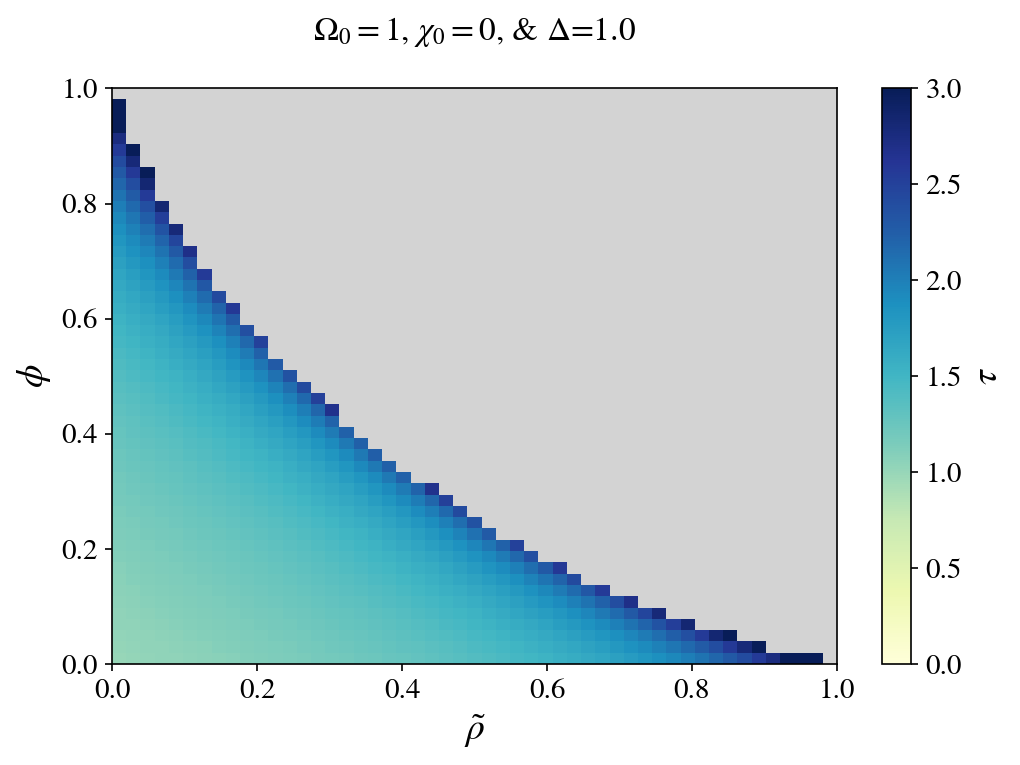

In [14]:
# ---------- Helper: first crossing time from below ----------
def first_cross_time(t, y, level=1.0):
    """
    Return the first time y crosses 'level' from below (linear interpolation).
    np.nan if no crossing within t.
    """
    y = np.asarray(y, float)
    t = np.asarray(t, float)
    idx = np.where((y[:-1] < level) & (y[1:] >= level))[0]
    if idx.size == 0:
        return np.nan
    k = idx[0]
    dy = y[k+1] - y[k]
    if dy == 0:
        return t[k+1]
    alpha = (level - y[k]) / dy
    return t[k] + alpha * (t[k+1] - t[k])

# ---------- Heatmap: x = \tilde{\rho}, y = \phi ----------
# Assumes you already defined: simulate_ode(delta, phi, rho_min, rho_max, t, ...)

# Time grid
T_total = 10.0
t = np.linspace(0.0, T_total, 600)

# Parameters
omega_zero = 1
rho_min = 0.0
delta = 1.0           # keeps \tilde{\rho} = \rho_max (since rho_min=0)
n_phi = 51
n_rmax = 51
phi_values = np.linspace(0.0, 1.0, n_phi)       # y-axis
rho_max_values = np.linspace(0.0, 1.0, n_rmax)  # will map to \tilde{\rho}
rho_tilde_values = delta * (rho_max_values - rho_min) + rho_min  # == rho_max

# Allocate heatmap (rows = phi, cols = \tilde{\rho})
T_hit = np.full((n_phi, n_rmax), np.nan, dtype=float)

# Fill grid using your simulate_ode (returns 5 values; last two ignored)
for i, phi in enumerate(phi_values):
    for j, rho_max in enumerate(rho_max_values):
        _, chi_t, rho_tilde, _, _ = simulate_ode(
            delta, float(phi), rho_min, float(rho_max), t, omega0=omega_zero,  method="DOP853"
        )
        T_hit[i, j] = first_cross_time(t, chi_t, level=1.0)

# Mask NaNs (no hit within the time window)
T_masked = np.ma.masked_invalid(T_hit)

# Plot heatmap
fig, ax = plt.subplots(figsize=(7.0, 5.2), dpi=150)
im = ax.imshow(
    T_masked,
    origin="lower",
    aspect="auto",
    extent=[rho_tilde_values[0], rho_tilde_values[-1], phi_values[0], phi_values[-1]],
    cmap="YlGnBu",
    vmin=0.,
    vmax = 3
)
# Colour for NaNs
im.cmap.set_bad(color="lightgrey")

ax.set_xlabel(r"$\tilde{\rho}$")
ax.set_ylabel(r"$\phi$")
ax.set_title(
    rf"$\Omega_{0} = {omega_zero}$, $\chi_{0} = {0}$, & $\Delta$={delta}" "\n"
    # r"(grey = no hit within window)"
)

cbar = fig.colorbar(im, ax=ax)
cbar.set_label(r"$\tau$")

plt.tight_layout()
plt.show()

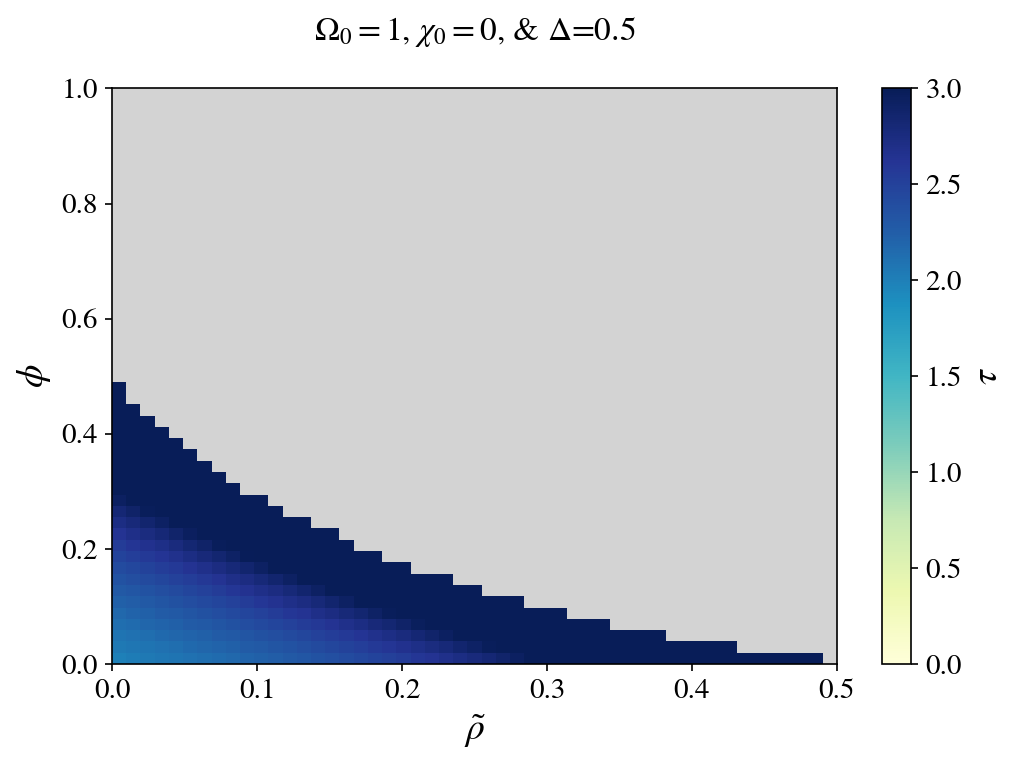

In [15]:
# ---------- Helper: first crossing time from below ----------
def first_cross_time(t, y, level=1.0):
    """
    Return the first time y crosses 'level' from below (linear interpolation).
    np.nan if no crossing within t.
    """
    y = np.asarray(y, float)
    t = np.asarray(t, float)
    idx = np.where((y[:-1] < level) & (y[1:] >= level))[0]
    if idx.size == 0:
        return np.nan
    k = idx[0]
    dy = y[k+1] - y[k]
    if dy == 0:
        return t[k+1]
    alpha = (level - y[k]) / dy
    return t[k] + alpha * (t[k+1] - t[k])

# ---------- Heatmap: x = \tilde{\rho}, y = \phi ----------
# Assumes you already defined: simulate_ode(delta, phi, rho_min, rho_max, t, ...)

# Time grid
T_total = 10.0
t = np.linspace(0.0, T_total, 600)

# Parameters
omega_zero = 1
rho_min = 0.0
delta = 0.5           # keeps \tilde{\rho} = \rho_max (since rho_min=0)
n_phi = 51
n_rmax = 51
phi_values = np.linspace(0.0, 1.0, n_phi)       # y-axis
rho_max_values = np.linspace(0.0, 1.0, n_rmax)  # will map to \tilde{\rho}
rho_tilde_values = delta * (rho_max_values - rho_min) + rho_min  # == rho_max

# Allocate heatmap (rows = phi, cols = \tilde{\rho})
T_hit = np.full((n_phi, n_rmax), np.nan, dtype=float)

# Fill grid using your simulate_ode (returns 5 values; last two ignored)
for i, phi in enumerate(phi_values):
    for j, rho_max in enumerate(rho_max_values):
        _, chi_t, rho_tilde, _, _ = simulate_ode(
            delta, float(phi), rho_min, float(rho_max), t, omega0=omega_zero,  method="DOP853"
        )
        T_hit[i, j] = first_cross_time(t, chi_t, level=1.0)

# Mask NaNs (no hit within the time window)
T_masked = np.ma.masked_invalid(T_hit)

# Plot heatmap
fig, ax = plt.subplots(figsize=(7.0, 5.2), dpi=150)
im = ax.imshow(
    T_masked,
    origin="lower",
    aspect="auto",
    extent=[rho_tilde_values[0], rho_tilde_values[-1], phi_values[0], phi_values[-1]],
    cmap="YlGnBu",
    vmin=0.,
    vmax = 3
)
# Colour for NaNs
im.cmap.set_bad(color="lightgrey")

ax.set_xlabel(r"$\tilde{\rho}$")
ax.set_ylabel(r"$\phi$")
ax.set_title(
    rf"$\Omega_{0} = {omega_zero}$, $\chi_{0} = {0}$, & $\Delta$={delta}" "\n"
    # r"(grey = no hit within window)"
)

cbar = fig.colorbar(im, ax=ax)
cbar.set_label(r"$\tau$")

plt.tight_layout()
plt.show()

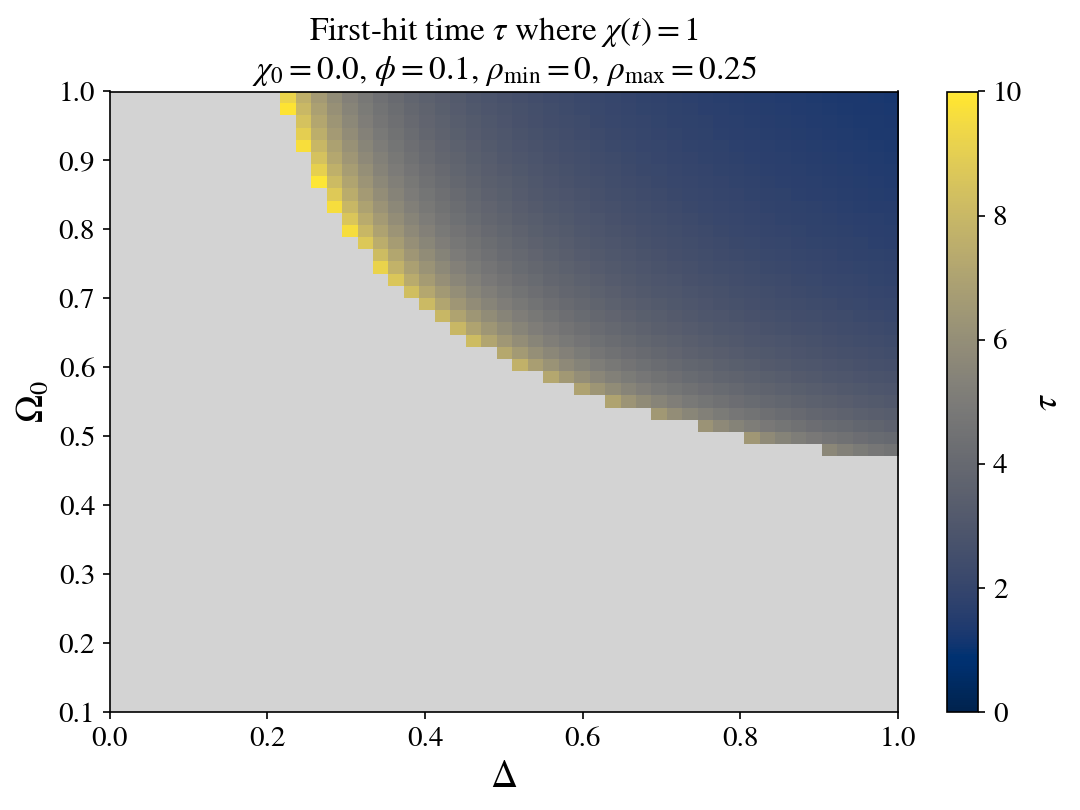

In [16]:
# --- Helper: first crossing time from below (same as before) ---
def first_cross_time(t, y, level=1.0):
    y = np.asarray(y, float); t = np.asarray(t, float)
    idx = np.where((y[:-1] < level) & (y[1:] >= level))[0]
    if idx.size == 0:
        return np.nan
    k = idx[0]
    dy = y[k+1] - y[k]
    if dy == 0:
        return t[k+1]
    alpha = (level - y[k]) / dy
    return t[k] + alpha * (t[k+1] - t[k])

# --- Time grid (longer window to capture slow cases) ---
T_total = 10.0
t = np.linspace(0.0, T_total, 1200)

# --- Fixed parameters ---
chi0 = 0.0
phi = 0.1
rho_min = 0
rho_max = 0.25

# --- Scan ranges (tweak as you like) ---
n_omega0 = 51
n_delta  = 51
omega0_values = np.linspace(0.1, 1.0, n_omega0)   # y-axis
delta_values  = np.linspace(0.0, 1.0, n_delta)     # x-axis (Δ ∈ [0,1])

# --- Allocate τ heatmap: rows = Ω0 index, cols = Δ index ---
Tau = np.full((n_omega0, n_delta), np.nan, dtype=float)

# --- Fill grid using your simulate_ode (returns 5 values; ignore last two) ---
for i, omega0 in enumerate(omega0_values):
    for j, delta in enumerate(delta_values):
        _, chi_t, rho_tilde, _, _ = simulate_ode(
            delta=delta, phi=phi, rho_min=rho_min, rho_max=rho_max,
            t=t, omega0=float(omega0), chi0=chi0, method="DOP853"
        )
        Tau[i, j] = first_cross_time(t, chi_t, level=1.0)

# --- Mask NaNs (no hit within the time window) ---
Tau_masked = np.ma.masked_invalid(Tau)

# --- Plot heatmap: x = Δ, y = Ω0, colours = τ ---
fig, ax = plt.subplots(figsize=(7.5, 5.5), dpi=150)
im = ax.imshow(
    Tau_masked,
    origin="lower",
    aspect="auto",
    extent=[delta_values[0], delta_values[-1], omega0_values[0], omega0_values[-1]],
    cmap="cividis",
    vmin=0.0, vmax=T_total
)
im.cmap.set_bad(color="lightgrey")  # no-hit region

ax.set_xlabel(r"$\Delta$")
ax.set_ylabel(r"$\Omega_0$")
ax.set_title(
    r"First-hit time $\tau$ where $\chi(t)=1$"
    + "\n"
    + rf"$\chi_0={chi0}$, $\phi={phi}$, $\rho_{{\min}}={rho_min}$, $\rho_{{\max}}={rho_max}$"
)

cbar = fig.colorbar(im, ax=ax)
cbar.set_label(r"$\tau$")

# Optional: add a few contours for readability
# CS = ax.contour(delta_values, omega0_values, Tau, levels=6, colors="white", linewidths=0.6)
# ax.clabel(CS, inline=True, fontsize=8, fmt="%.1f")

plt.tight_layout()
plt.show()

/var/folders/rr/16wv6ts1785fz6_2qhr5bc2m0000gn/T/ipykernel_322/179892220.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("cividis")


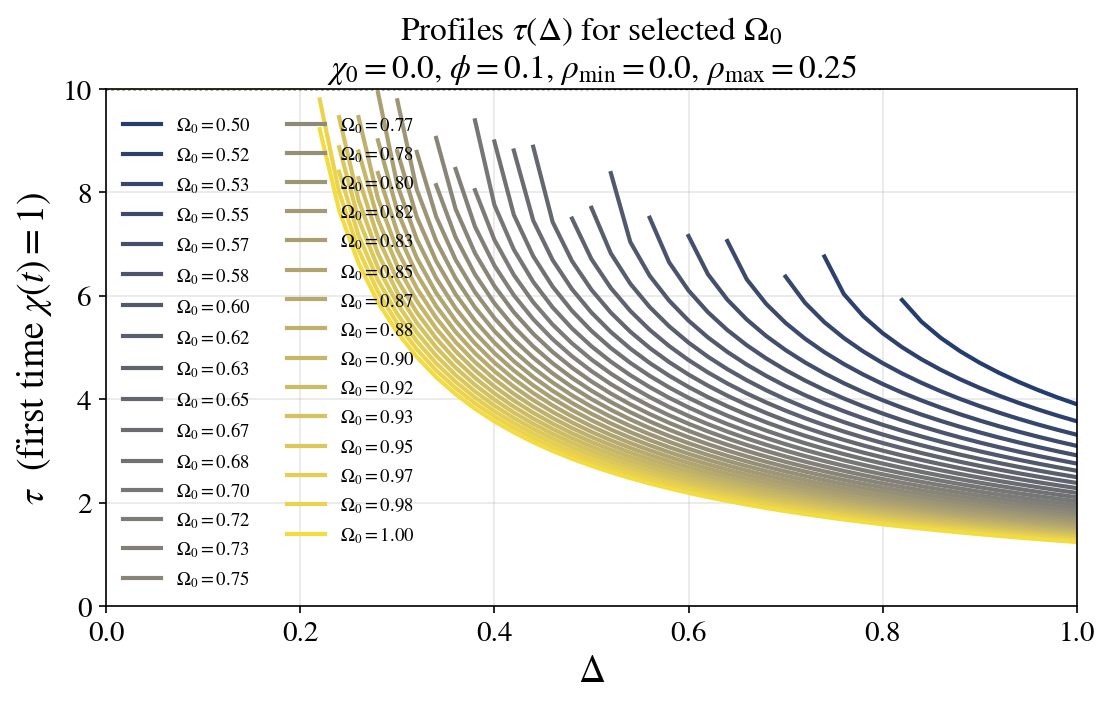

In [17]:
# --- Helper stays the same ---
def first_cross_time(t, y, level=1.0):
    y = np.asarray(y, float); t = np.asarray(t, float)
    idx = np.where((y[:-1] < level) & (y[1:] >= level))[0]
    if idx.size == 0:
        return np.nan
    k = idx[0]
    dy = y[k+1] - y[k]
    if dy == 0:
        return t[k+1]
    alpha = (level - y[k]) / dy
    return t[k] + alpha * (t[k+1] - t[k])

# --- Time grid (match your reference settings) ---
T_total = 10.0
t = np.linspace(0.0, T_total, 1200)

# --- Fixed parameters (as requested) ---
chi0 = 0.0
phi = 0.1
rho_min = 0.0
rho_max = 0.25

# --- Δ scan ---
n_delta  = 51
delta_values  = np.linspace(0.0, 1.0, n_delta)

# --- Choose one or more Ω0 to profile ---
n_omega0 = 31
omega0_list = np.linspace(0.5, 1.0, n_omega0)

# --- Compute τ(Δ) for each Ω0 ---
Tau_profiles = {}
for omega0 in omega0_list:
    tau = np.full_like(delta_values, np.nan, dtype=float)
    for j, delta in enumerate(delta_values):
        _, chi_t, _, _, _ = simulate_ode(
            delta=delta, phi=phi, rho_min=rho_min, rho_max=rho_max,
            t=t, omega0=float(omega0), chi0=chi0, method="DOP853"
        )
        tau[j] = first_cross_time(t, chi_t, level=1.0)
    Tau_profiles[omega0] = tau

# --- Plot ---
fig, ax = plt.subplots(figsize=(7.5, 4.8), dpi=150)

cmap = cm.get_cmap("cividis")
colors = cmap(np.linspace(0.15, 0.95, len(omega0_list)))

for color, omega0 in zip(colors, omega0_list):
    tau = Tau_profiles[omega0]
    # solid where τ is finite, dotted at top for no-hit (optional)
    mask = ~np.isnan(tau)
    if mask.any():
        ax.plot(delta_values[mask], tau[mask], color=color, lw=2,
                label=rf"$\Omega_0={omega0:.2f}$")
    # Optional: mark no-hit region at top boundary
    if (~mask).any():
        ax.plot(delta_values[~mask], np.full((~mask).sum(), T_total),
                linestyle=":", color=color, lw=1)

ax.set_xlim(0, 1)
ax.set_ylim(0, T_total)
ax.set_xlabel(r"$\Delta$")
ax.set_ylabel(r"$\tau$  (first time $\chi(t)=1$)")
ax.set_title(
    r"Profiles $\tau(\Delta)$ for selected $\Omega_0$"
    + "\n"
    + rf"$\chi_0={chi0}$, $\phi={phi}$, $\rho_{{\min}}={rho_min}$, $\rho_{{\max}}={rho_max}$"
)
ax.grid(True, alpha=0.3)
ax.legend(ncol=2, fontsize=9, frameon=False)

plt.tight_layout()
plt.show()